# Загрузка Order book из CSV

In [154]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [155]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [156]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [157]:
df_history.shape

(2409285, 11)

In [158]:
df_history.sort_values('dt').tail()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-10-15 19:51:36,11266859.0,19,binance,ETH/USDT,217.009995,1.46361,None,sell,39358925.0,memory,2018-10-15 19:51:38.5966667
2018-10-15 19:51:36,11266858.0,19,binance,ETH/USDT,217.009995,0.42487,None,sell,39358924.0,memory,2018-10-15 19:51:38.5966667
2018-10-15 19:51:37,11266861.0,19,binance,ETH/USDT,217.080002,10.00000,None,buy,39358926.0,memory,2018-10-15 19:51:38.5966667
2018-10-15 19:51:37,11266863.0,19,binance,ETH/USDT,217.100006,1.97003,None,buy,39358928.0,memory,2018-10-15 19:51:38.5966667
2018-10-15 19:51:37,11266862.0,19,binance,ETH/USDT,217.089996,2.73210,None,buy,39358927.0,memory,2018-10-15 19:51:38.5966667


In [200]:
#перевод в минуты
hist = df_history[['price', 'amount']].resample('120min').mean()
hist.shape

(274, 2)

In [201]:
hist.fillna(method='ffill', inplace=True)

In [202]:
hist.head()

,price,amount
dt,,
2018-09-23 00:00:00,239.943689,2.928401
2018-09-23 02:00:00,240.385881,2.748185
2018-09-23 04:00:00,238.458418,4.209348
2018-09-23 06:00:00,239.412555,2.799688
2018-09-23 08:00:00,240.669311,3.156576


In [203]:
model = ARIMA(hist.price, order=(1,1,1))

In [204]:
model_fit = model.fit()

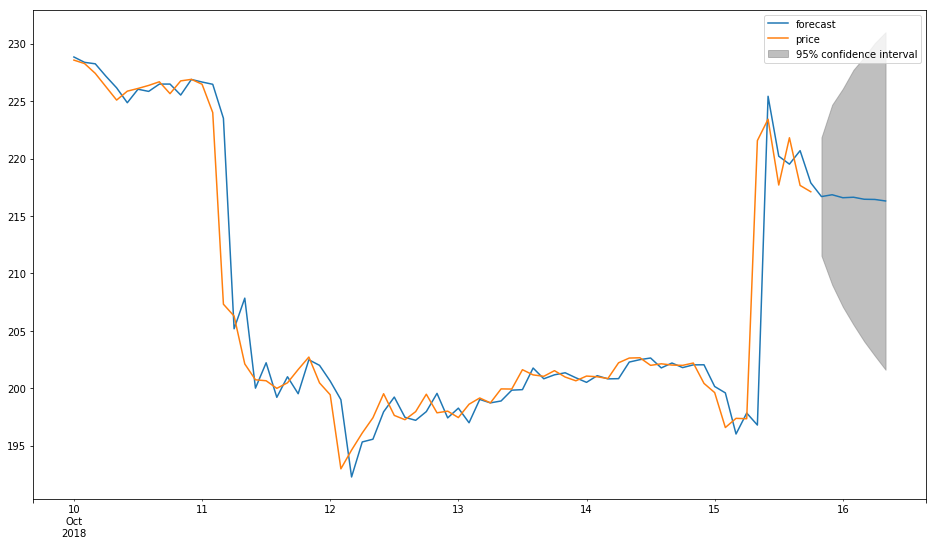

In [216]:
plt.rcParams['figure.figsize'] = [16, 9]
_= model_fit.plot_predict(start = '2018-10-10', end = 280)


In [206]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  273
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -651.344
Method:                       css-mle   S.D. of innovations              2.629
Date:                Mon, 15 Oct 2018   AIC                           1310.689
Time:                        20:03:47   BIC                           1325.127
Sample:                    09-23-2018   HQIC                          1316.484
                         - 10-15-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0838      0.173     -0.486      0.628      -0.422       0.254
ar.L1.D.price    -0.7223      0.107     -6.780      0.000      -0.931      -0.513
ma.L1.D.price     0.8678      0.077     

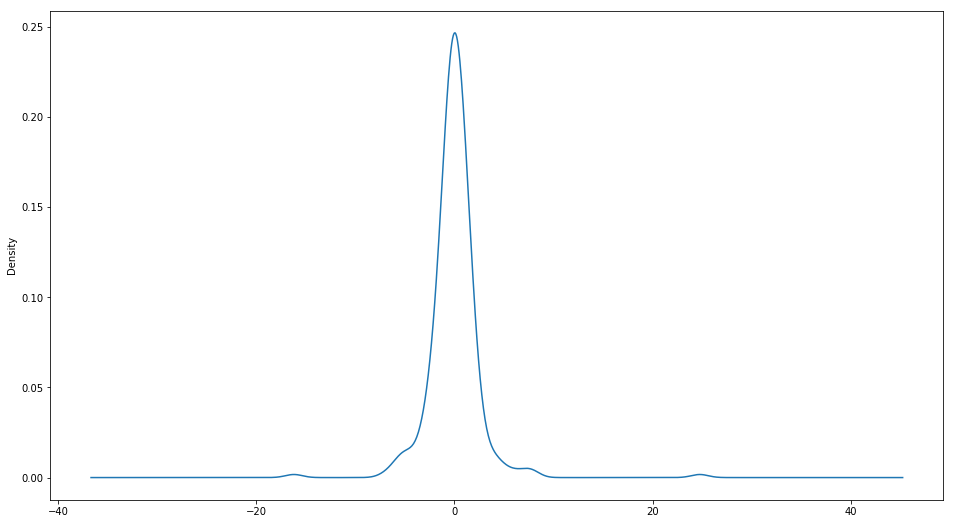

In [207]:
model_fit.resid.plot(kind='kde')

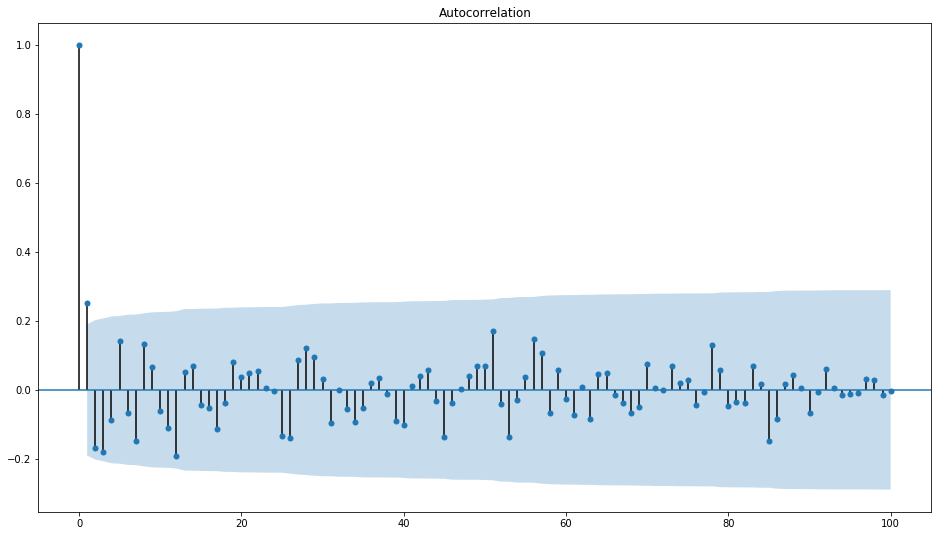

In [208]:
_ = plot_acf(hist['2018-09-28 0:00':'2018-10-06 21:00'].price.diff().dropna(), lags=100, alpha=0.05)